## Exercício Treliça

<img src="trelica_simples.png" style="width:200px;height:200px"/>

### Importando módulos

In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importando Dados

In [348]:
nos = pd.read_excel('trelica.xlsx', sheet_name='nos')
barras = pd.read_excel('trelica.xlsx', sheet_name='barras')

# Ajustando o numero de nos e barras
nos.index += 1
barras.index += 1

# Remoção dos NaN's trocando por zeros
nos.fillna(0, inplace=True)

### Representação dos Nós e das Barras

In [349]:
nos

,X,Y,RX,RY,FX,FY
1,0,0,1.0,1.0,0,0
2,4000,0,0.0,1.0,0,0
3,4000,6000,0.0,0.0,12000,0


In [350]:
barras

,N1,N2,A,E
1,1,2,2300,200000
2,2,3,2300,200000
3,1,3,2300,200000


### Propriedades das barras

In [351]:
Ls = []
senos = []
cossenos = []

for barra in barras.index:
    # Nós que compõem as barras
    N1, N2 = barras.loc[barra, ['N1', 'N2']]
    
    # Determinação das coordenadas
    x1, y1 = nos.loc[N1, ['X', 'Y']]
    x2, y2 = nos.loc[N2, ['X', 'Y']]
    
    # Projeções nos eixos X e Y
    LX = x2 - x1
    LY = y2 - y1
    
    # Tamanho real da barra
    L = np.sqrt(LX**2 + LY**2)
    
    # Seno e cosseno
    seno = LY/L
    coss = LX/L 
    
    # Pendurando nas listas
    Ls.append(L)
    senos.append(seno)
    cossenos.append(coss)

barras['L'] = Ls
barras['sen'] = senos
barras['cos'] = cossenos

barras

,N1,N2,A,E,L,sen,cos
1,1,2,2300,200000,4000.000000,0.00000,1.0000
2,2,3,2300,200000,6000.000000,1.00000,0.0000
3,1,3,2300,200000,7211.102551,0.83205,0.5547


### Matriz de Rigidez Local e Global

In [352]:
# Pré alocando a matriz de rigidez global
maxgl = 2*len(nos.index)
K = np.zeros([maxgl, maxgl])
K2 = np.zeros([maxgl, maxgl])

print(np.shape(K), '\n')
print(np.size(K), '\n', '\n')

for barra in barras.index:
    N1, N2, A, E, L, sen, cos = barras.loc[barra]
    
    # Matriz de rigidez no sistema local 
    Kl = E*A/L*np.array([[ 1, 0,-1, 0],
                         [ 0, 0, 0, 0], 
                         [-1, 0, 1, 0],
                         [ 0, 0, 0, 0]])

    # Matriz de rotação
    Mrot = np.array([[ cos,  sen,    0,   0],
                     [-sen,  cos,    0,   0],
                     [    0,   0,  cos, sen],
                     [    0,   0, -sen, cos]])
    
       # Rotação da matriz de rigidez
    Klr = np.dot(np.dot(Mrot.T, Kl), Mrot)
    
        # Determinação dos gls
    gl1 = int(2*N1-1)
    gl2 = int(2*N1)
    gl3 = int(2*N2-1)
    gl4 = int(2*N2)
    
    # Acoplamento da matriz global 
    K[gl1-1:gl2, gl1-1:gl2] += Klr[0:2, 0:2]
    K[gl3-1:gl4, gl1-1:gl2] += Klr[2:4, 0:2]
    K[gl1-1:gl2, gl3-1:gl4] += Klr[0:2, 2:4]
    K[gl3-1:gl4, gl3-1:gl4] += Klr[2:4, 2:4]
    

print(K)

    

(6, 6) 

36 
 

[[ 134627.8530972    29441.7796458  -115000.               0.
   -19627.8530972   -29441.7796458 ]
 [  29441.7796458    44162.6694687        0.               0.
   -29441.7796458   -44162.6694687 ]
 [-115000.               0.          115000.               0.
        0.               0.        ]
 [      0.               0.               0.           76666.66666667
        0.          -76666.66666667]
 [ -19627.8530972   -29441.7796458        0.               0.
    19627.8530972    29441.7796458 ]
 [ -29441.7796458   -44162.6694687        0.          -76666.66666667
    29441.7796458   120829.33613537]]


### Condições de Contorno

In [353]:
Kr = np.copy(K)  

# Impondo condições de apoio
for no in nos.index:
    # Importando dados dos nós 
    RX, RY = nos.loc[no, ['RX','RY']]
    
    # Determinar graus de liberdade
    gl1 = int(2*no-1)
    gl2 = int(2*no)
    
    # Condição dos apoios
    if RX == 1:
        Kr[:, gl1-1] = 0
        Kr[gl1-1, :] = 0
        Kr[gl1-1, gl1-1] = 1
        print('Restringindo deslocamento em X no nó {}.'.format(no))
        
    if RY == 1:
        Kr[:, gl2-1] = 0
        Kr[gl2-1, :] = 0
        Kr[gl2-1, gl2-1] = 1
        print('Restringindo deslocamento em Y no nó {}.'.format(no))

Restringindo deslocamento em X no nó 1.
Restringindo deslocamento em Y no nó 1.
Restringindo deslocamento em Y no nó 2.


### Verificação da consistência da matriz de rigidez

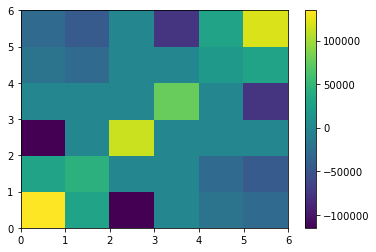

In [354]:
plt.pcolormesh(K)
plt.colorbar()

### Montagem do vetor de Forças

In [355]:
F = np.zeros([maxgl])

for no in nos.index:
    # Importando dados dos nós 
    FX, FY = nos.loc[no, ['FX','FY']]
    
    # Determinar graus de liberdade
    gl1 = int(2*no-1)
    gl2 = int(2*no)
    
    # Se existir carga aplica no vetor
    if FX != 0: 
        F[gl1-1] = FX
        
    if FY != 0: 
        F[gl2-1] = FY
        
print(F)

[    0.     0.     0.     0. 12000.     0.]


### Teste da matriz singular

In [356]:
# Resolução do sistema
# A.x = b 
print("Determinante da matriz K=", np.linalg.det(K)) # sem as C.C
print("Determinante da matriz Kr=", np.linalg.det(Kr)) # já com as C.C

Determinante da matriz K= -4.777920827224089e-20
Determinante da matriz Kr= 173052238140317.06


### Cálculo dos Deslocamentos

In [357]:
D = np.linalg.solve(Kr, F)
print(D)

[ 0.          0.          0.          0.          0.96355    -0.23478261]


### Cálculo das Reações de Apoio

In [358]:
R = np.dot(K, D)
print(R)

[-12000. -18000.      0.  18000.  12000.      0.]


### Determinação dos esforços internos

In [359]:
Esf = []

for barra in barras.index:
        N1, N2, A, E, L, sen, cos = barras.loc[barra]

        # Matriz de rigidez no sistema local 
        Kl = E*A/L*np.array([[ 1, 0,-1, 0],
                             [ 0, 0, 0, 0], 
                             [-1, 0, 1, 0],
                             [ 0, 0, 0, 0]])

        # Matriz de rotação
        Mrot = np.array([[ cos,  sen,    0,   0],
                         [-sen,  cos,    0,   0],
                         [    0,   0,  cos, sen],
                         [    0,   0, -sen, cos]])

        # Determinação dos gls
        gl1 = int(2*N1-1)
        gl2 = int(2*N1)
        gl3 = int(2*N2-1)
        gl4 = int(2*N2)

        # Capturar os deslocamentos
        Dlg = np.zeros([4])
        Dlg[0] = D[gl1-1]
        Dlg[1] = D[gl2-1]
        Dlg[2] = D[gl3-1]
        Dlg[3] = D[gl4-1]

        # Rotaciona Dlg
        Dl = np.dot(Mrot, Dlg)

        # Determina esforços no sentido da barra 
        Fl = np.dot(Kl, Dl)
        FAx = Fl[2]
        Esf.append(FAx)


In [360]:
Esf

[0.0, -17999.99999999999, 21633.30765278393]

### Determinação das tensões nas barras

In [361]:
Ten = np.divide(Esf, A)
print(Ten)

[ 0.         -7.82608696  9.40578594]


### Inserindo os Esforços e Tensões na planilha

In [362]:
barras['Esf'] = Esf
barras['Ten'] = Ten
barras

,N1,N2,A,E,L,sen,cos,Esf,Ten
1,1,2,2300,200000,4000.000000,0.00000,1.0000,0.000000,0.000000
2,2,3,2300,200000,6000.000000,1.00000,0.0000,-18000.000000,-7.826087
3,1,3,2300,200000,7211.102551,0.83205,0.5547,21633.307653,9.405786


### Inserindo os deslocamentos na planilha

In [363]:
Dx = []
Dy = []

for no in nos.index:
    gl1 = int(2*no-1)
    gl2 = int(2*no)
    
    Dx.append(D[gl1-1])
    Dy.append(D[gl2-1])

nos['Dx'] = Dx
nos['Dy'] = Dy 

nos

,X,Y,RX,RY,FX,FY,Dx,Dy
1,0,0,1.0,1.0,0,0,0.00000,0.000000
2,4000,0,0.0,1.0,0,0,0.00000,0.000000
3,4000,6000,0.0,0.0,12000,0,0.96355,-0.234783


                                                     Fim da rotina !!!!
                                

 <img src="ufrgs.jpg" style="width:150px;height:150px"/>                    
 
 
 Author: COSTA, P.O.B.                                                                           
                              
                              
                              

                